# **Segmentation of skin lesions**

## **IMA201 Project** - Télécom Paris

## BENEDETTI DA ROSA Giovanni and DE MOURA JÚNIOR Paulo Roberto

## Coordinator: Loïc Le Folgoc



# **Introduction**

The incidence of melanomas and other types of skin cancer is increasing year by year due to greater exposure to ultraviolet rays. Early detection of this type of cancer greatly aids in its treatment. Therefore, since image segmentation methods are useful for this purpose, in this work we try to find an image segmentation method to skin lesion that are that expensive computationally.


In the first part of this work, a brief description of the image processing methods that compose our implementation will be provided. Following that, we will explain the functioning of our pipeline, along with examples and the reasoning behind our choices.

The image processing methods chosen were based in the following articles:
* https://www.sciencedirect.com/science/article/abs/pii/S0031320316303442
* https://link.springer.com/chapter/10.1007/978-3-319-18720-4_2

#**Image processing methods**

## **Color Space Conversion**

The first step involves determining a color space to be used. Considering the ease of working with single component images, we will proceed in this manner. Within our code, two conversion options are available: **RGB to grayscale** or RGB to the *L* component of the **LAB color space**. We implemented it in this way to test which colorspace would work better in our case.

**RGB to grayscale**

In the conversion of RGB to grayscale, a weighted sum of the three channels is calculated, where the weights correspond to the perceived intensity of each color. This formula reflects the human eye's sensitivity to different colors, with green contributing the most to perceived brightness.

$$Gray←0.299⋅R+0.587⋅G+0.114⋅B$$

**L from LAB colorspace**

The LAB color space, on the other hand, is designed to more closely mimic human vision. It consists of three components: $L$ (lightness), $A$ (green to red), and $B$ (blue to yellow). To get the $L$ component first we need to convert RGB to XYZ colorspace and then XYZ to LAB.
### RGB to XYZ:
$$R,G,B \in [0,1]$$

$$ X = R \times 0.4124564 + G \times 0.3575761 + B \times 0.1804375 $$

$$ Y = R \times 0.2126729 + G \times 0.7151522 + B \times 0.0721750 $$

$$ Z = R \times 0.0193339 + G \times 0.1191920 + B \times 0.9503041 $$

### XYZ to LAB:

$$ L = 116 \times f(Y/Y_n) - 16 $$

$$ A = (X/X_n - Y/Y_n) \times 500 $$

$$ B = (Y/Y_n - Z/Z_n) \times 200 $$

Where:

$$X_n = 95.047$$
$$Y_n=100.000$$
$$Z_n=108.883$$

(D65 illuminant)

$$ f(t) = \begin{cases} t^{1/3} & \text{if } t > (6/29)^3 \\ \frac{t}{3(6/29)^2} + \frac{4}{29} & \text{otherwise} \end{cases} $$

Source: https://en.wikipedia.org/wiki/Color_space


## **Mathematical Morphology**

In this section there is a brief description of Mathematical Morphology operations.

1. **Erosion (E):**
   Erosion is a morphological operation that involves shrinking the boundaries of an object in an image. This is achieved by sliding a structuring element (\(B\)) across the image($X$) and determining the minimum pixel value within the region covered by the structuring element.
   $$E(X, B) = X ⊖ B = \{x | ∀b ∈ B; x + b ∈ X\} $$

2. **Dilation (D):**
   Dilation is the counterpart to erosion and is employed to expand the boundaries of objects in an image. Similar to erosion, dilation involves the use of a structuring element, but, in this case, the maximum pixel value within the region covered by the structuring element is determined.
   $$ D(X,B)=X⊕B= \{x+b∣x∈X,b∈B\}$$

3. **Opening:**
   Opening is a combination of erosion followed by dilation. It is particularly useful in removing small-scale noise and fine structures from binary images. The process begins with an erosion operation, which eliminates small protrusions and finer details. Subsequently, a dilation operation is applied to restore the main structure, resulting in a cleaner and more refined representation.
   $$ X_B = D(E(X, B), B) = (X \ominus B) \oplus B $$

4. **Closing (C):**
   Closing is the inverse of opening, involving dilation followed by erosion. This operation is effective in closing small gaps or holes within objects in a binary image. Initially, a dilation operation is executed to bridge small gaps, and subsequently, an erosion operation is applied to maintain the overall structure, resulting in more complete and connected objects.
   $$  X^{B} = E(D(X, B), B) = (X
    \oplus B) \ominus B $$

These four mathematical morphology operations are gonna be used along the pipeline implemented in this work.

Source: https://en.wikipedia.org/wiki/Mathematical_morphology


## **Flood fill algorithm**
We are using the flood fill algorithm implemented in Scikit-Image library to mark some regions when we are generating a mask for the region of interest in the image. The algorithm consists to fill a connected region with a specified value (color) and to do that, it needs the coordinates of a starting point inside the connected region and the value to fill that region.

The implementation of the flood fill algorithm in Scikit-Image consists in doing a seed-based region growing, which has the following workflow:

1. **Initialization**: start with a seed pixel and initialize an empty queue.

1. **Enqueue Seed Pixe**l: place the seed pixel into the queue.

1. **Processing Loop**: while the queue is not empty
  1. Dequeue a pixel from the front of the queue.
  1. Process the dequeued pixel.
  1. Enqueue any unprocessed neighboring pixels (horizontal and vertical neighbours) that meet the criteria (same value of the seed pixel) and have not been enqueued before.
  1. Mark the processed pixel to avoid reprocessing.

Sources:
https://en.wikipedia.org/wiki/Region_growing ,
https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_floodfill.html

## **Otsu Method**

The Otsu method is used to do an automatic threshold of an image into a binary image, using the histogram of the image. The method consists in finding the threshold $t$ that minimizes the within-class variance, which is the same as maximize the between-class variance. So considering that $t$ is a value between the minimum and maximum intensity values in the image, we want to:

- Find $t$ that minimizes
$$\sigma^2_W(t) = \omega_1(t) \sigma_1^2(t) + \omega_2(t) \sigma_2^2(t)$$

or

- Find $t$ that maximizes
$$ \sigma_B^2(t) = \sigma^2_T - \sigma^2_W = w_1(t) \cdot w_2(t) \cdot [m_1(t) - m_2(t)]^2 $$

where
$L$ is the number of bins in the histogram and
$$ w_1(t) = \sum_{i=0}^{t} P(i) $$
$$ w_2(t) = \sum_{i=t+1}^{L-1} P(i) $$
$$ m_1(t) = \frac{1}{w_1(t)} \sum_{i=0}^{t} i \cdot P(i) $$
$$ m_2(t) = \frac{1}{w_2(t)} \sum_{i=t+1}^{L-1} i \cdot P(i) $$
$$\sigma_1^2(t) = \frac{1}{w_1(t)} \sum_{i=0}^{t} (i - m_1(t))^2$$
$$\sigma_2^2(t) = \frac{1}{w_2(t)} \sum_{i=t+1}^{L-1} (i - m_2(t))^2$$

So when the between-classes variance is maximized, it is possible to segmentated the image in two different regions.

Source: https://en.wikipedia.org/wiki/Otsu%27s_method

## **Conected Components Labelling**

The objective of applying this algorithm is to label connected regions in a binary mask. By default, the library OpenCV considers the neighbourhood of a pixel being its closest vertical, horizontal and diagonal pixels (8 connectivity).
The implementation of the connected components algorithm in OpenCV is based in a technique called union-find, which has the following simplified workflow:

First step:

1.  For each non-zero pixel:

    1. If it has no non-zero neighbours, it receives a new label.

    2. If it has one non-zero neighbour it receives the same label as the neighbour.

    3. If it has more than one non-zero neighbour, there are two cases:
        1. The neighbours all have the same label. So the current pixel receives the same label.

        2. The neighbours have different labels. When encountering pixels with different labels among their neighbors, the algorithm addresses this by initially assigning the current pixel the lowest label among its neighbors. Simultaneously, it maintains a record of equivalences for connected labels—indicating which distinct labels should be treated as equivalent. The resolution of these equivalences occurs during the second step of the algorithm.


Second step:

1. For each pixel with a label:
  1. Check if one label has one equivalent label and solve it.


After that, for each label, the algorithm counts the number of pixels to obtain an area of each label and other statistics metrics.

Source: https://en.wikipedia.org/wiki/Connected-component_labeling

##**Dice**
To validate our method, a comparison is made between the segmentation mask obtained with our algorithm and the segmentation mask created by a specialist, which we assume as the true segmentation. For this purpose, a statistical indicator measuring the similarity of the two samples has been chosen, the Sørensen-Dice index (D).

$$D = 2\frac{|X \cap Y|}{|X| + |Y|}$$

Where $X$ represents our segmentation mask and $Y$ represent the specialist's segmentation mask. The Sørensen-Dice index provides a quantitative measure of the overlap or similarity between the two segmentation results, in which we can easily check that $D \in [0,1]$, because when $X$ and $Y$ do not have any intersection $D = 0$ and when the two images are completely overlaped $D = 1$.

Source: https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

# **Segmentation algorithm**

##**Hair Removal**
It is plausible for a skin image to have skin hair present in it, which could intervene in our thresholding method. We can visualize below one example of that in our dataset.
To deal with this, we decide to implement a function called `remove_skin_hair` to paint the regions where the skin hairs are using the neighbouring non hair pixel values. The workflow of this function is explained step by step below.


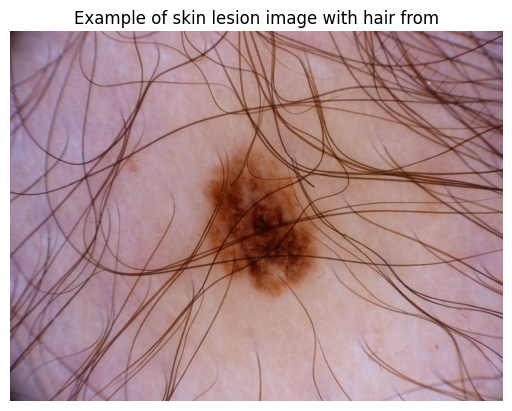

In [ ]:
image = cv2.imread('/content/ISIC_0000095.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title('Example of skin lesion image with hair from')
plt.axis('off')
plt.show()

1. First of all, we convert the image to grayscale using an OpenCV function, which gave us better results when compared to LAB. Then, we apply a median filter to the image using a square kernel of size 47, which was determined experimentally as a reasonable size. This filter removes the majority of the hair from the image, since the hairs are thin and thus they don't affect the median in the square kernel, which can be seen below.

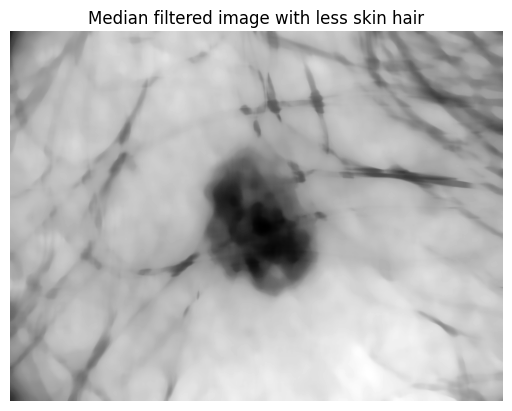

In [ ]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
hair_kernel_size = 47
median_blur_image = cv2.medianBlur(image, hair_kernel_size)
plt.imshow(median_blur_image, cmap='gray')
plt.title('Median filtered image with less skin hair')
plt.axis('off')
plt.show()

2. Subsequently, we subtract the original image from the hairless image, resulting in an image containing almost only the hair.

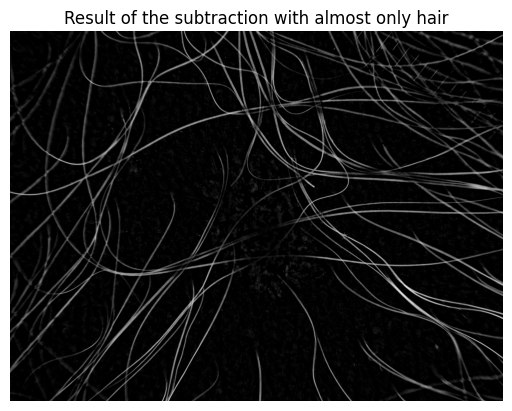

In [ ]:
only_hair = cv2.subtract(median_blur_image, image)
plt.imshow(only_hair, cmap='gray')
plt.title('Result of the subtraction with almost only hair')
plt.axis('off')
plt.show()


3. Following this, we binarize the previous image using a  threshold equal to 2% of the span of the image values, determined experimentally as a reasonable value.

4. In addition to this, we perform an Opening and Closing operation in the binary mask to enhance the hair features for subsequent removal while mitigating noise.

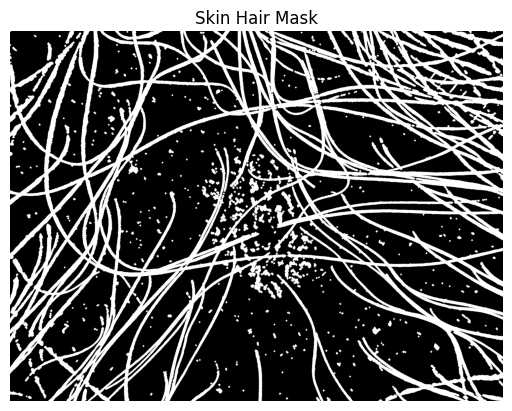

In [ ]:
_, mask = cv2.threshold(only_hair, int(0.02*255),255,cv2.THRESH_BINARY)
kernel = morpho.disk(2)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)
plt.imshow(mask, cmap='gray')
plt.title('Skin Hair Mask')
plt.axis('off')
plt.show()

5. In the final step, for each point in the original image that corresponds to a white value in the hair mask, the pixel value is assigned as the local median value of its non hair neighbors, which is an inpainting method. In the end, we have an image that has almost no hair in it, which will be returned by the function. We can see that some points of the lesion were in the hair mask, but we assumed that inpainting some darker parts of the lesion wouldn't change our segmentation results since its contours wouldn't change significantly.

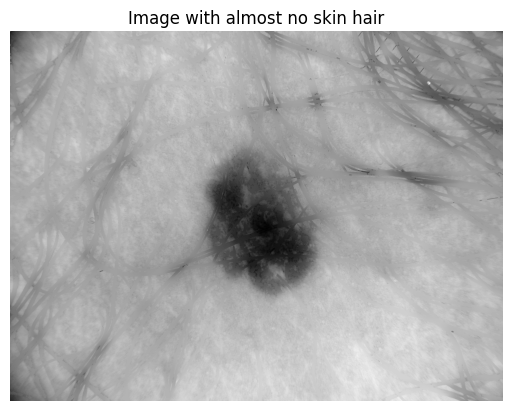

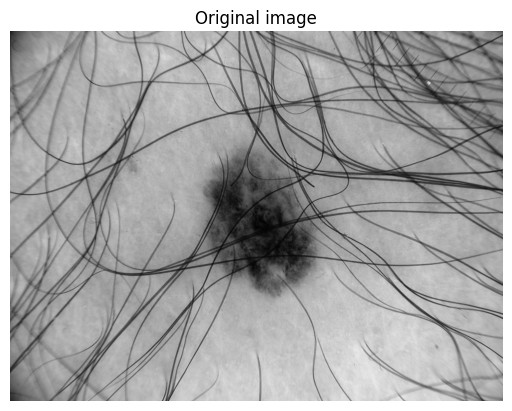

In [ ]:
inpainted_image = image.copy()

# Get the coordinates of the noisy regions from the binary mask
noisy_coords = np.where(mask > 0)

for y, x in zip(*noisy_coords):
    y_start, y_end = max(0, y - 40), min(image.shape[0], y + 40 + 1)
    x_start, x_end = max(0, x - 40), min(image.shape[1], x + 40 + 1)

    neighborhood = image[y_start:y_end, x_start:x_end]

    if neighborhood.size > 0:
        inpainted_image[y, x] = np.median(neighborhood)

plt.imshow(inpainted_image, cmap = 'gray')
plt.title('Image with almost no skin hair')
plt.axis('off')
plt.show()

plt.imshow(image, cmap = 'gray')
plt.title('Original image')
plt.axis('off')
plt.show()

##**Finding the region of interest**

In some images of the dataset there are black marks in circular form as shown below. We are interested in applying the OTSU method to get a threshold for the image and these marks could interfere with it as there would be several pixels in the image with value close to 0. It would be a problem also to generate the lesion mask, as the lesion usually has pixels that are darker than the skin pixels. To solve this, we created a function `find_good_region` that receives the pretreated image (without skin hair) and returns a binary mask where we atribute the value 0 for the pixels that are part of the black marks and the value 255 otherwise. In the cells below it's explained the operations performed by the function step-by-step.


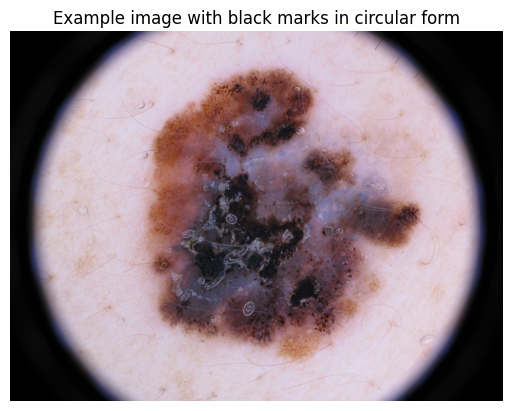

In [ ]:
image = cv2.imread('ISIC_0000140.jpg')
imagergb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(imagergb)
plt.title('Example image with black marks in circular form')
plt.axis('off')
plt.show()

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

First we create a binary mask where the darker pixels (black marks)
receive 255 and the whiter pixels receive 0. We used the value 50 as threshold determined experimentally to not take too many parts of the lesion into the mask.

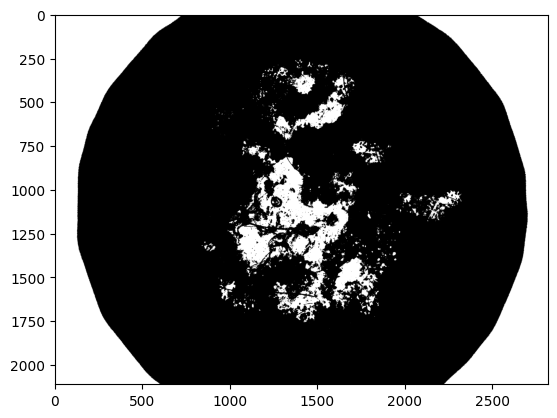

In [ ]:
_, good_region = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY_INV)
plt.imshow(good_region, cmap = 'gray')
plt.show()

Then we apply a morphological transformation to remove noise and close holes in the dark structures (white regions in the mask).

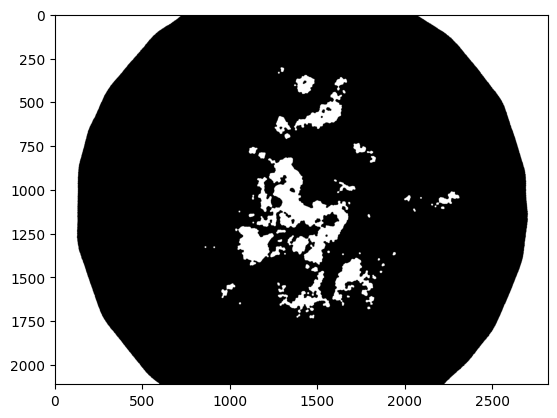

In [ ]:
kernel = morpho.disk(5)
good_region = cv2.morphologyEx(good_region, cv2.MORPH_OPEN, kernel)
good_region = cv2.morphologyEx(good_region, cv2.MORPH_CLOSE, kernel)
plt.imshow(good_region, cmap ='gray')
plt.show()

After filtering we apply the Flood Fill algorithm to mark regions belonging to the circular dark region with a different value (128).

To apply this method, we use the four corners from the mask generated before as the starting points. In addition, we've put a flag to see if the mask has values 255 in the corners or not, which indicates if there are darker regions in the original image, and if it doesn't, we return a mask filled with the value 255, to indicate that to region of interest is the whole image.

At this point we have the position of the black marks (if there are any) then we just make a mask using these positions.

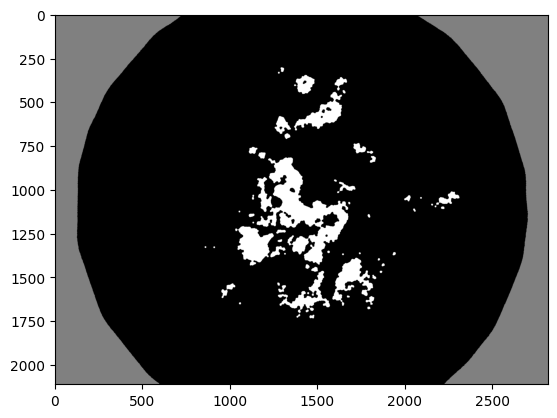

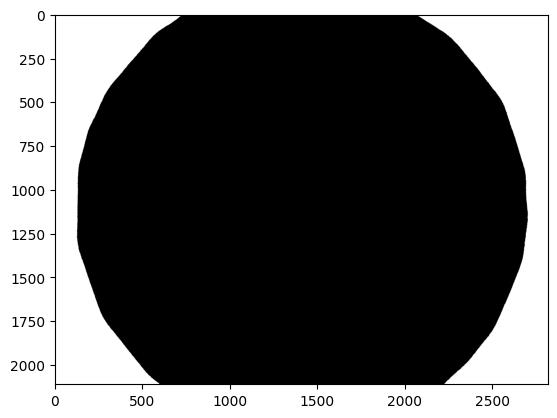

In [ ]:
flag_painted = 0
l = image

if(good_region[0,0]==255):
  regions = flood_fill(good_region, seed_point=(0,0), new_value=128)
  flag_painted = 1
if(good_region[l.shape[0]-1,l.shape[1]-1]==255):
  regions = flood_fill(regions, seed_point=(l.shape[0]-1,l.shape[1]-1), new_value=128)
  flag_painted = 1
if(good_region[0,l.shape[1]-1]==255):
  regions = flood_fill(regions, seed_point=(0,l.shape[1]-1), new_value=128)
  flag_painted = 1
if(good_region[l.shape[0]-1,0]==255):
  regions = flood_fill(regions, seed_point=(l.shape[0]-1,0), new_value=128)
  flag_painted = 1

plt.imshow(regions, cmap = 'gray')
plt.show()

if(flag_painted == 0):
  good_region = np.full_like(image, 255, dtype ='uint8')

good_region = (255*(regions == 128)).astype('uint8')

plt.imshow(good_region, cmap = 'gray')
plt.show()

Finally we apply a dilation in the mask so that it covers entirely the black marks regions. Then we get the inverse of the mask and the final result will have only the position of pixels that are not in the black marks region.

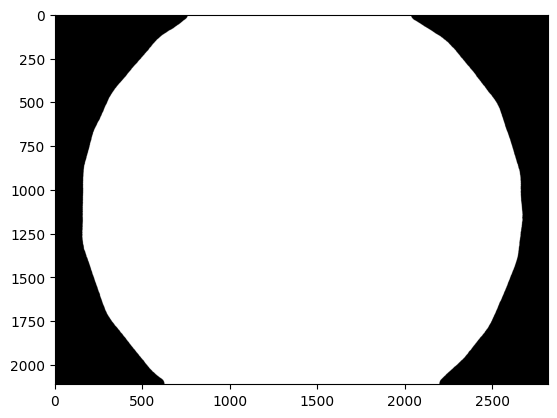

In [ ]:
kernel = morpho.disk(30)
good_region = cv2.morphologyEx(good_region, cv2.MORPH_DILATE, kernel)
good_region = 255 - good_region
plt.imshow(good_region, cmap='gray')
plt.show()

## **Thresholding with Otsu**

Now that we have a region where the lesion should be contained and we have removed the possible hairs, we can threshold the image. In the next lines, we explain the operations performed by the function `segmentation`.

1. First of all, we only take the points that are in the mask defined by the 'find_good_region' function and apply the Otsu threshold method.

Obtained threshold:  142.0


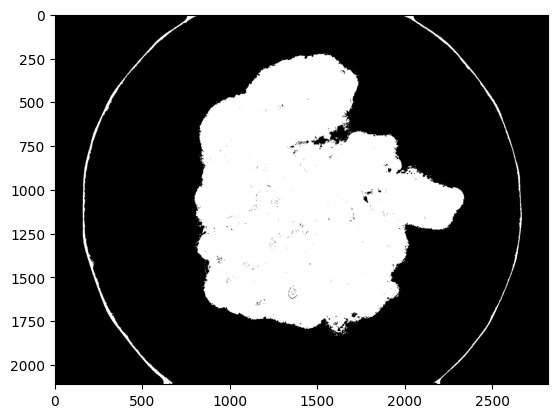

In [ ]:
img = cv2.imread('ISIC_0000140.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
inpainted = remove_skin_hair(img, 40)

good_region = find_good_region(inpainted)

#################### previous steps above ######################

inner_circle_values = inpainted[(good_region == 255)]

otsu_threshold, _ = cv2.threshold(inner_circle_values, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("Obtained threshold: ", otsu_threshold)

segmentation_mask = np.zeros_like(inpainted)
segmentation_mask = np.where(good_region == 0, 0, segmentation_mask)
segmentation_mask = np.where((good_region != 0) & (inpainted < otsu_threshold), 255, segmentation_mask)

plt.imshow(segmentation_mask, cmap='gray')
plt.show()


3. After that we filter the noise in the mask applying an opening. To compensate undersegmentation of the otsu method, we dilate the mask. Finally we apply an closing to remove holes inside the mask.

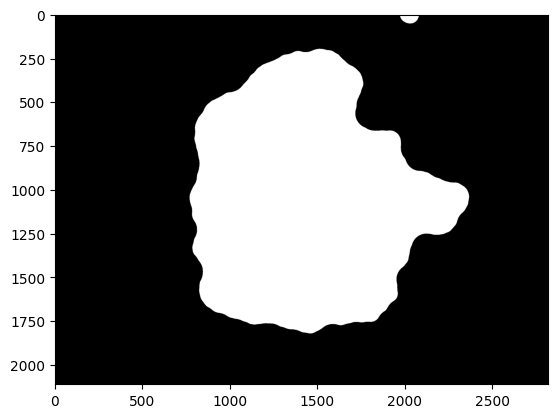

In [ ]:
kernel = morpho.disk(20)
segmentation_mask = cv2.morphologyEx(segmentation_mask, cv2.MORPH_OPEN, kernel)
kernel = morpho.disk(30)
segmentation_mask = cv2.morphologyEx(segmentation_mask, cv2.MORPH_DILATE, kernel)
kernel = morpho.disk(85)
segmentation_mask = cv2.morphologyEx(segmentation_mask, cv2.MORPH_CLOSE, kernel)

plt.imshow(segmentation_mask, cmap='gray')
plt.show()


4. Finally, we apply the Connected Component Labelling algorithm and we keep only the connected component with the greatest area, which should represent the skin lesion.


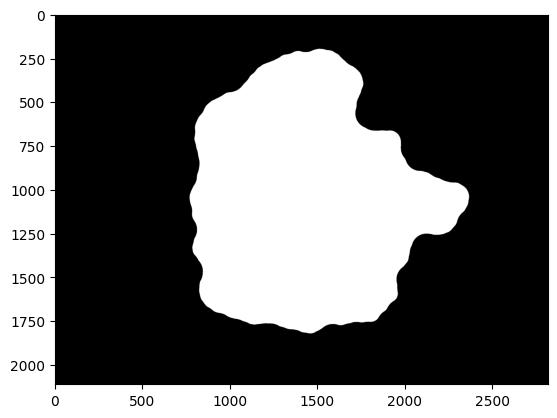

In [ ]:
numlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmentation_mask)
matrix = np.column_stack((range(numlabels), stats[:,4]))
sorted_matrix = sorted(matrix, key=lambda row: row[1], reverse=True)

#draw the biggest contour
final_mask = (255*(labels == sorted_matrix[1][0])).astype('uint8')

plt.imshow(final_mask, cmap = 'gray')
plt.show()

## **Dice computation**

Once we have a generate mask by our algorithm and the true mask made by an specialist, we can compare the two using the dice statistical coefficient.

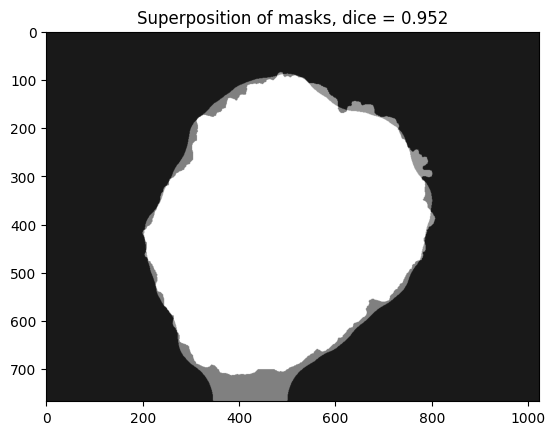

In [ ]:
img = cv2.imread('ISIC_0000008.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
inpainted = remove_skin_hair(img, 40)
good_region = find_good_region(inpainted)
final_mask = segmentation(inpainted, good_region)

#################### previous steps above ######################

mask_prevision = final_mask
mask_true = cv2.imread('ISIC_0000008_Segmentation.png', cv2.IMREAD_GRAYSCALE)

intersect = np.sum(mask_true*mask_prevision)
fsum = np.sum(mask_true>0)
ssum = np.sum(mask_prevision>0)
dice = (2 * intersect ) / (fsum + ssum)
dice = round(dice, 3)

plt.imshow(mask_prevision, alpha=0.8, cmap='gray')
plt.imshow(mask_true, alpha=0.5, cmap='gray')
plt.title('Superposition of masks, dice = {:}'.format(dice))
plt.show()

# **Results**

To assess the precision and accuracy of our segmentation method, we applied the described pipeline uniformly across all images, without distinction, and we used the dice mean to assess the accuracy and the dice amostral deviation to assess the precision of our segmentation method.

Except for image 4 that makes our algorithm return a null mask, we could generate a mask to all images. In some of them, the dice  was lower than others and this is possibly happening because:

1. When the lesion values are close to the skin values (such as image 4) there's a superposition of the pixel values in the histogram and Otsu performance is very affected, making the segmentation very poor. We tried to do an histogram equalization in the image 4 to see if it would make it easier to apply Otsu, but the equalization accentuated irregularities by redistributing intensity values, then the image became noisy (as shown in the cell below);

2. When the lesion has two zones with very different intensities our segmentation keeps only the biggest zone, this happens because we have actually 3 peaks in the histogram and Otsu thresholding can only separate 2 efficiently, which is a limitation of the method itself;

3. The true segmentation masks made by specialists look convex in some cases (such as image 9, 12 and 15) and we didn't implement a convex hull operation in our pipeline, in this case we can get very different results.

Finally, the result obtained for the mean dice is 0.870 with standard deviation 0.095, which was obtained eliminating the dice coefficient of image 4 (null dice). The results masks obtained for each image and a table with the all dice coefficient can be seen in our python script.

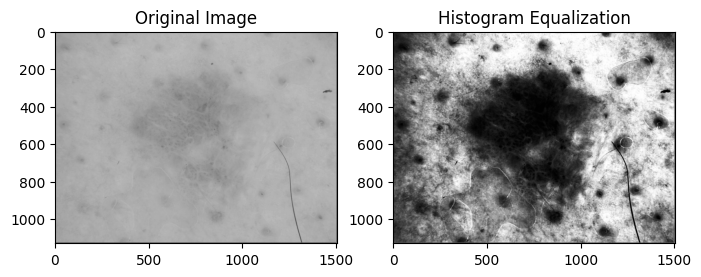

In [ ]:
path = 'ISIC_0000024.jpg'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
equalize = cv2.equalizeHist(img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
ax1.imshow(img, cmap='gray')
ax1.set_title("Original Image")
ax2.imshow(equalize, cmap='gray')
ax2.set_title("Histogram Equalization")
plt.show()

# **Conclusion**

In conclusion, our method was capable to segmentate skin lesions using less complex techniques of image processing in the great majority of our dataset, which meets the initial objective of this project.

Notably, our algorithm successfully generated masks for all images except in image 4, which resulted in a null mask. While the overall average Dice coefficient was 0.870, indicating substantial accuracy, variations were observed, which is reflected in our standard deviation equal to 0.095. The lower Dice coefficients in some instances are likely attributed to challenges arising when the lesion color closely resembles the skin color or the lesion has multiple predominant intensities. Finally, in some cases, the convex feature of some reference masks is possible affecting the Dice coefficient.

In order to overcome the lesion intensities limitations, techniques such as textures or neural networks could be explored to get better results. In addition, the implementation of a convex hull operation in the pipeline could help increase the Dice in some cases.

#Auxiliar code

In [ ]:
#############AUXILIAR CODE IGNORE IT#################
import cv2
from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb
from skimage.segmentation import flood_fill
import skimage.morphology as morpho
from matplotlib import pyplot as plt
from numpy.lib.function_base import median
import numpy as np

def remove_skin_hair(image, kernel_size):
    hair_kernel_size = 47
    median_blur_image = cv2.medianBlur(image, hair_kernel_size)
    only_hair = cv2.subtract(median_blur_image, image)

    _, mask = cv2.threshold(only_hair, int(0.02*255),255,cv2.THRESH_BINARY)
    kernel = morpho.disk(2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)
    # Create a copy of the input image to store the inpainted result
    inpainted_image = image.copy()

    # Get the coordinates of the noisy regions from the binary mask
    noisy_coords = np.where(mask > 0)

    for y, x in zip(*noisy_coords):
        y_start, y_end = max(0, y - kernel_size), min(image.shape[0], y + kernel_size + 1)
        x_start, x_end = max(0, x - kernel_size), min(image.shape[1], x + kernel_size + 1)

        neighborhood = image[y_start:y_end, x_start:x_end]

        if neighborhood.size > 0:
            inpainted_image[y, x] = np.median(neighborhood)

    return inpainted_image

def find_good_region(image):
  _, good_region = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY_INV)
  kernel = morpho.disk(5)

  good_region = cv2.morphologyEx(good_region, cv2.MORPH_OPEN, kernel)
  good_region = cv2.morphologyEx(good_region, cv2.MORPH_CLOSE, kernel)

  flag_painted = 0

  if(good_region[0,0]==255):
    regions = flood_fill(good_region, seed_point=(0,0), new_value=128)
    flag_painted = 1
  if(good_region[image.shape[0]-1,image.shape[1]-1]==255):
    regions = flood_fill(regions, seed_point=(image.shape[0]-1,image.shape[1]-1), new_value=128)
    flag_painted = 1
  if(good_region[0,image.shape[1]-1]==255):
    regions = flood_fill(regions, seed_point=(0,image.shape[1]-1), new_value=128)
    flag_painted = 1
  if(good_region[image.shape[0]-1,0]==255):
    regions = flood_fill(regions, seed_point=(image.shape[0]-1,0), new_value=128)
    flag_painted = 1

  if(flag_painted == 0):
    return np.full_like(image, 255, dtype ='uint8')

  good_region = (255*(regions == 128)).astype('uint8')

  kernel = morpho.disk(30)
  good_region = cv2.morphologyEx(good_region, cv2.MORPH_DILATE, kernel)
  good_region = 255 - good_region
  return good_region

def segmentation(inpainted, good_region):
  inner_circle_values = inpainted[(good_region == 255)]

  otsu_threshold, _ = cv2.threshold(inner_circle_values, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  #print("Obtained threshold: ", otsu_threshold)

  segmentation_mask = np.zeros_like(inpainted)
  segmentation_mask = np.where(good_region == 0, 0, segmentation_mask)
  segmentation_mask = np.where((good_region != 0) & (inpainted < otsu_threshold), 255, segmentation_mask)

  #selecting only the region with the biggest area
  kernel = morpho.disk(20)
  segmentation_mask = cv2.morphologyEx(segmentation_mask, cv2.MORPH_OPEN, kernel)
  kernel = morpho.disk(30)
  segmentation_mask = cv2.morphologyEx(segmentation_mask, cv2.MORPH_DILATE, kernel)
  kernel = morpho.disk(85)
  segmentation_mask = cv2.morphologyEx(segmentation_mask, cv2.MORPH_CLOSE, kernel)

  if(np.all(segmentation_mask == 0)): #check if the mask is null everywhere
    return segmentation_mask

  numlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmentation_mask)
  matrix = np.column_stack((range(numlabels), stats[:,4]))
  sorted_matrix = sorted(matrix, key=lambda row: row[1], reverse=True)

  #draw the biggest contour
  final_mask = (255*(labels == sorted_matrix[1][0])).astype('uint8')

  return final_mask

def DICE_COE(mask_true, mask_prevision):
    #mask_prevision = 255 - mask_prevision #invert the result mask
    intersect = np.sum(mask_true*mask_prevision)
    fsum = np.sum(mask_true>0)
    ssum = np.sum(mask_prevision>0)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = round(dice, 3)
    return dice